### PUBG

In a PUBG game, up to 100 players start in each match (matchId). Players (Id) can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. During the game, players can pick up different amunitions, revive downed-but-not-dead (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset description


|Feature|Description|
|----- |-----|
|DBNOs|Number of enemy players knocked.|
|assists|Number of enemy players this player damaged that were killed by teammates.|
|boosts|Number of boost items used.|
|damageDealt|Total damage dealt. Note: Self inflicted damage is subtracted.|
|headshotKills|Number of enemy players killed with headshots.|
|heals|Number of healing items used.|
|Id|Player’s Id|
|killPlace|Ranking in match of number of enemy players killed|
|killPoints|Kills-based external ranking of players. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.|
|killStreaks|Max number of enemy players killed in a short amount of time.|
|kills|Number of enemy players killed.|
|longestKill|Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.|
|matchDuration|Duration of match in seconds.|
|matchId|ID to identify matches. There are no matches that are in both the training and testing set.|
|matchType|String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.|
|rankPoints|Elo-like ranking of players. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes the place of “None”.|
|revives|Number of times this player revived teammates.|
|rideDistance|Total distance traveled in vehicles measured in meters.|
|roadKills|Number of kills while in a vehicle.|
|swimDistance|Total distance traveled by swimming measured in meters.|
|teamKills|Number of times this player killed a teammate.|
|vehicleDestroys|Number of vehicles destroyed.|
|walkDistance|Total distance traveled on foot measured in meters.|
|weaponsAcquired|Number of weapons picked up.|
|winPoints|Win-based external ranking of players. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.|
|groupId|ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.|
|numGroups|Number of groups we have data for in the match.|
|maxPlace|Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.|
|winPlacePerc|The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.|

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import warnings
warnings.filterwarnings("ignore")

In [5]:
df=pd.read_csv('/content/drive/MyDrive/DataSets/Pubg.csv')

In [6]:
df.head()

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,2093518,a3e3cea9f2e314,c9f6eaa81245b5,a3d8693390584c,0,0,25.93,0,0,0,84,1437,0,0,0.000,1403,squad-fpp,31,29,-1,0,0.0,0,0.0,0,0,151.30,1,1525,0.0667
1,3701672,43e4be7ad72cc7,521836de101ee8,b65de9055327e0,0,0,36.71,0,0,0,57,1225,0,0,0.000,1971,squad-fpp,30,30,-1,0,0.0,0,0.0,0,0,1918.00,7,1516,0.5862
2,2059784,9a68690e31fdff,4a72ffa2cebd90,d6aad3f9830e60,0,1,47.73,0,0,0,50,0,0,0,0.000,1741,solo-fpp,96,89,1516,0,4088.0,0,0.0,0,0,820.00,7,0,0.8105
3,1302036,b147e1bd448fc4,9a8991656b3fea,d931c0932d8aca,0,0,0.00,0,0,0,56,1286,0,0,0.000,1738,squad-fpp,28,27,-1,1,0.0,0,0.0,0,0,38.81,0,1515,0.5556
4,297180,d818b4edd59612,eece87c8b846b3,ec2b5ed94baae3,0,2,100.00,0,0,3,31,0,1,1,7.737,2193,solo,99,95,1482,0,918.4,0,0.0,0,0,1721.00,5,0,0.6429


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111742 entries, 0 to 1111741
Data columns (total 30 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1111742 non-null  int64  
 1   Id               1111742 non-null  object 
 2   groupId          1111742 non-null  object 
 3   matchId          1111742 non-null  object 
 4   assists          1111742 non-null  int64  
 5   boosts           1111742 non-null  int64  
 6   damageDealt      1111742 non-null  float64
 7   DBNOs            1111742 non-null  int64  
 8   headshotKills    1111742 non-null  int64  
 9   heals            1111742 non-null  int64  
 10  killPlace        1111742 non-null  int64  
 11  killPoints       1111742 non-null  int64  
 12  kills            1111742 non-null  int64  
 13  killStreaks      1111742 non-null  int64  
 14  longestKill      1111742 non-null  float64
 15  matchDuration    1111742 non-null  int64  
 16  matchType        1

In [8]:
df.isnull().sum()

Unnamed: 0         0
Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

#### Kills

Let us first look at Kills, the kill count of the players

In [9]:
df[df['kills']>0].shape

(479593, 30)

In [10]:
print("On an average a person kills {:.4f} players, 99% of people have {} kills or less, while the maximum kills ever recorded is {}.".format(df['kills'].mean(),df['kills'].quantile(0.99), df['kills'].max()))

On an average a person kills 0.9255 players, 99% of people have 7.0 kills or less, while the maximum kills ever recorded is 72.


[(0.0, 15.0)]

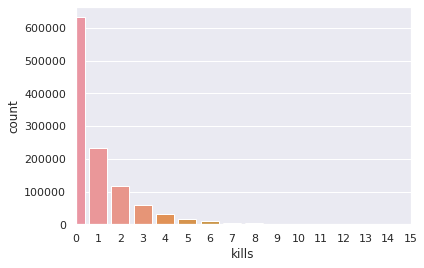

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
plot = sns.countplot(x="kills", data=df)
plot.set(xlim=(0, 15))

#### Kills 
(number of enemy players killed by a player)
Here in the above plot we can see most of the players struggling to kill the enemies, there are more 0 kills and maximum was 6 kills. Let us see if these people who are not killing the enemies are doing some damage to the opponents.

### Damage Dealt
Damage dealt by people who kill 0 enemies

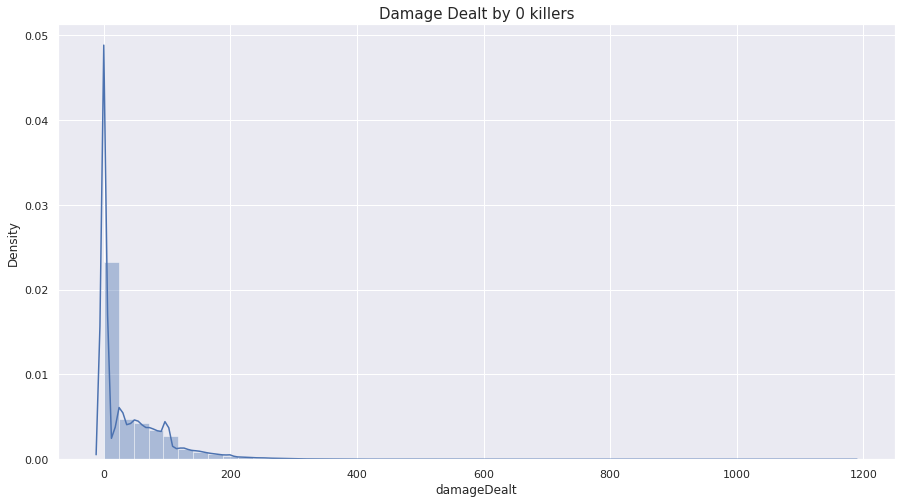

In [12]:
data = df.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,8))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [13]:
print("A total of {} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(df)))
data1 = df[df['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(df)))

A total of 4197 players (0.3775%) have won without a single kill!
A total of 1199 players (0.1078%) have won without dealing damage!


By looking at the graph we see that most the people who have 0 kills did not do much damage to the opponents.
Well there are few people who win without even making a single kill or dealing with damage. Looks like an outlier

#### Weapons Acquired

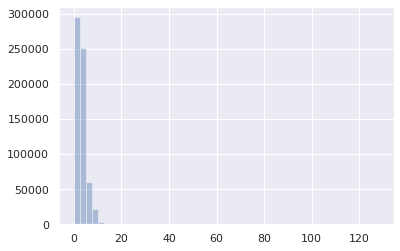

In [17]:
damageDealt = df[df['kills']==0]
sns.distplot(x=damageDealt["weaponsAcquired"],kde=False)  

From the above graph we can see people who do zero damage didn't even find a weapon, which means they were most likely killed at the beginning of the game.

#### Assists 
Number of enemy players this player damaged that were killed by teammates.

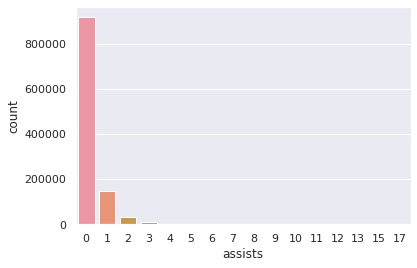

In [18]:
sns.countplot(x="assists", data=df)


The damages done to the enemies before the teammates kill the enemies is also less. That means the kills done by the players are mostly done enemies who do not have any damage

#### DBNOs
Number of enemy players knocked

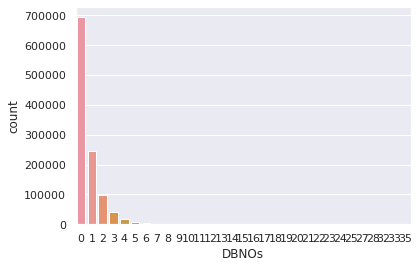

In [19]:
sns.countplot(x="DBNOs", data=df)

The number of enemy players knocked is also less. Let us know look at headshots.
#### Headshots

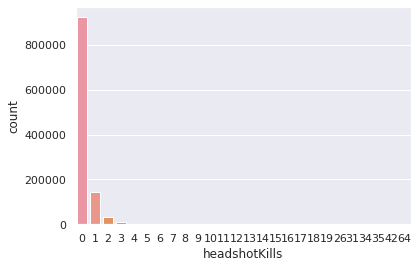

In [20]:
sns.countplot(x="headshotKills", data=df)

In [21]:
df[df['headshotKills']>1].shape

(43862, 30)

In [22]:
df.shape

(1111742, 30)

Out of 1111742 the headshot count is 43862 that is 0.4%
Also, out of 1111742 the kills greater than 0 are 479593 that is 43% 

Let us see the Walking distance distribution now

### Walking distance


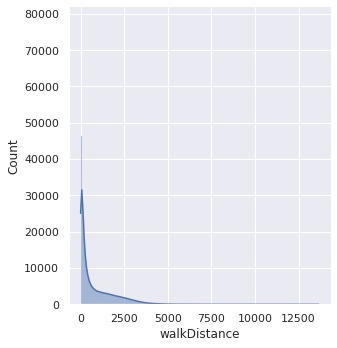

In [23]:
sns.displot(x=damageDealt["walkDistance"],kde=True)  

In [24]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(df[df['walkDistance'] == 0]), 100*len(df[df['walkDistance']==0])/len(df)))

24936 players (2.2430%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


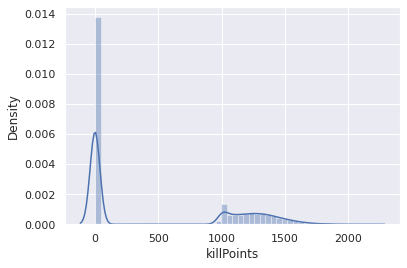

In [25]:
sns.distplot(df["killPoints"],kde=True)  

#### Effect of killing on Winning percentage

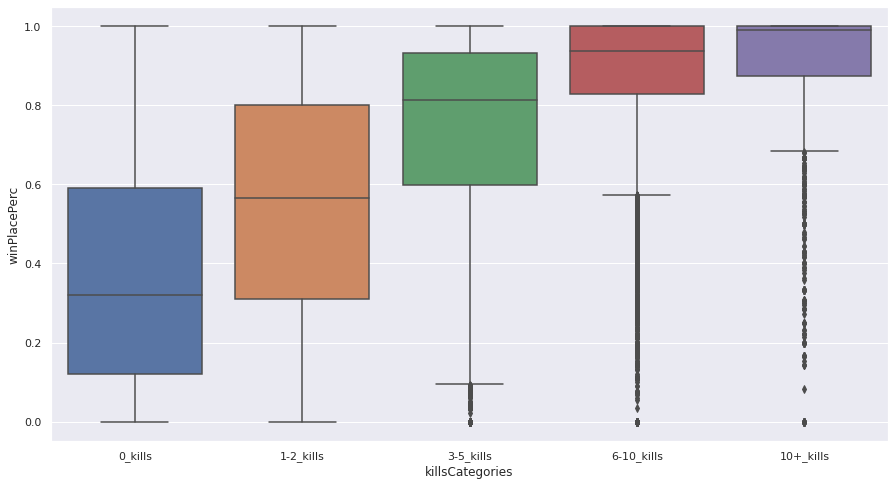

In [26]:
kills = df.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

As shown above by the increasing mean of win percentage placement, we found that kill count was correlated with our target variable, which makes sense because more kills usually means a player is better skilled and will rank closer to the top.

#### Analysing Running

In [27]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(df)))

24556 players (2.0422%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


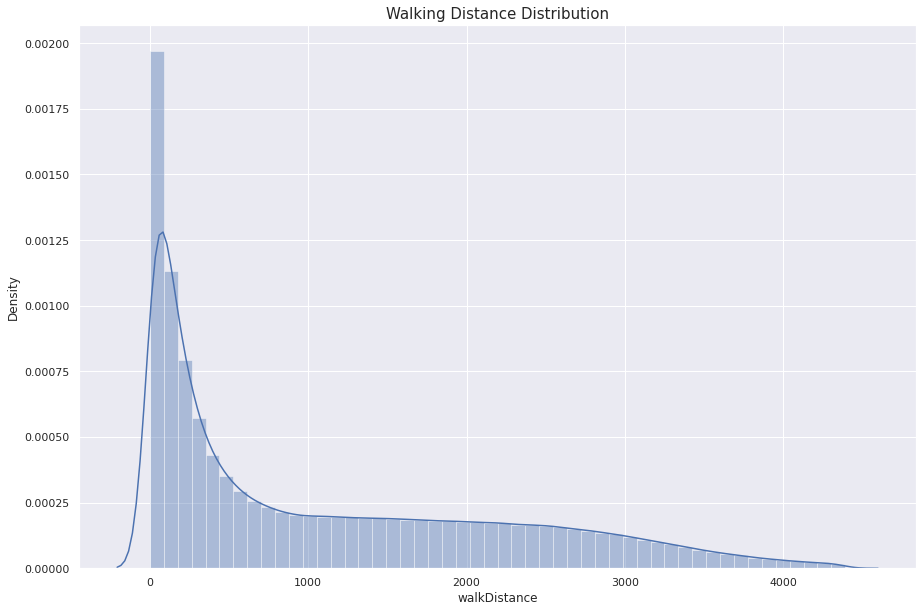

In [28]:
data = df.copy()
data = data[data['walkDistance'] < df['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

#### Analysing Running: Effect of Running on Winning Percentage
The scatter plot below indicates there is a high correlation between running and winning percentage. This isn’t something new since the longer you’re alive, the more you run and more is the chance of winning.

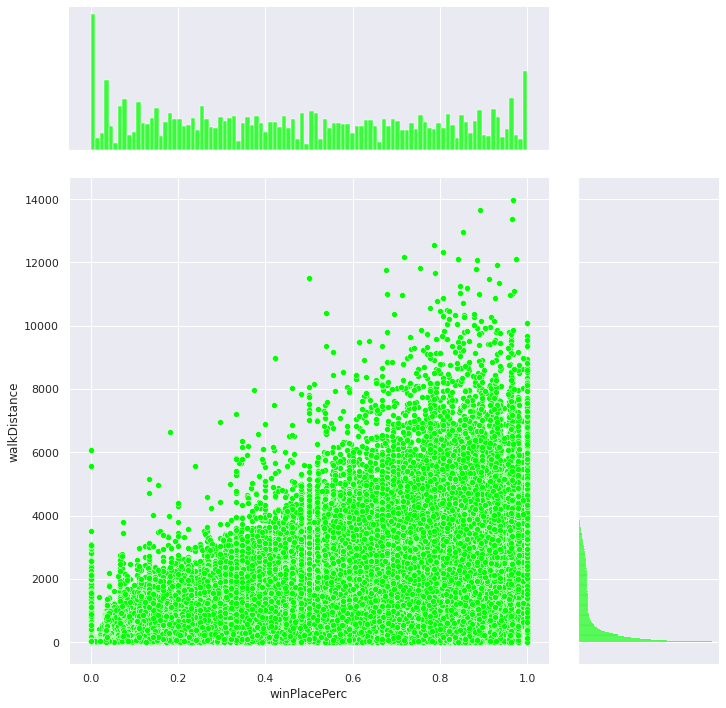

In [29]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=df, height=10, ratio=3, color="lime")
plt.show()

#### Analysing Riding

In [30]:
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE RIDER rode for {}m.".format(df['rideDistance'].mean(), df['rideDistance'].quantile(0.99), df['rideDistance'].max()))

An average person drives for 604.2m, 99% of people have drived 6968.0m or less, while THE RIDER rode for 35400.0m.


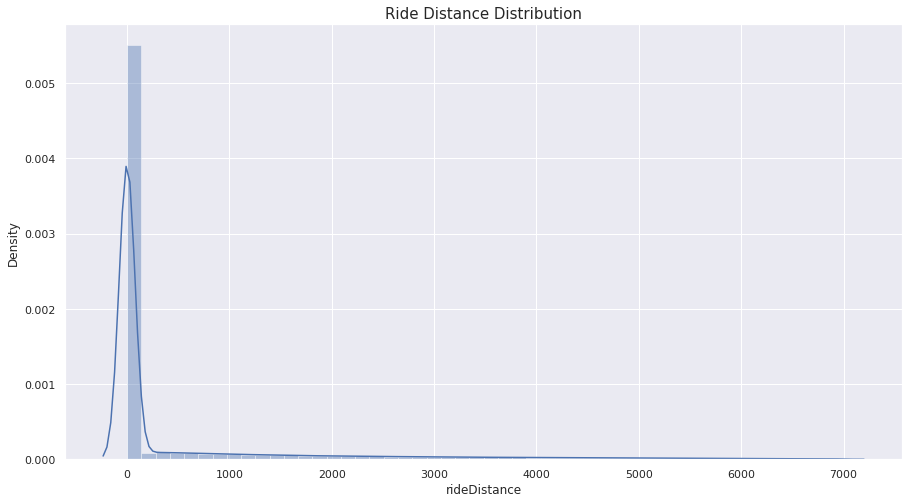

In [31]:
data = df.copy()
data = data[data['rideDistance'] < df['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [32]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(df)))

827573 players (23.0811%) drived for 0 meters. This means that they like trekking more than riding.


#### Analysing Riding: Effect of Riding on Winning Percentage¶

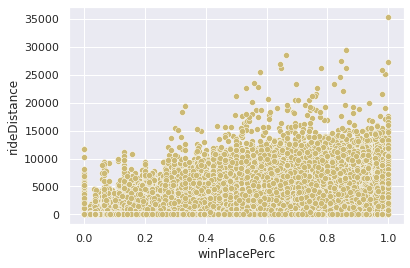

In [35]:
sns.scatterplot(x="winPlacePerc", y="rideDistance", data=df, color="y")
plt.show()

Theoretically, if a player is able to destroy the vehicle it indicates the he/she is skilled. Let's check if this theory is correct.



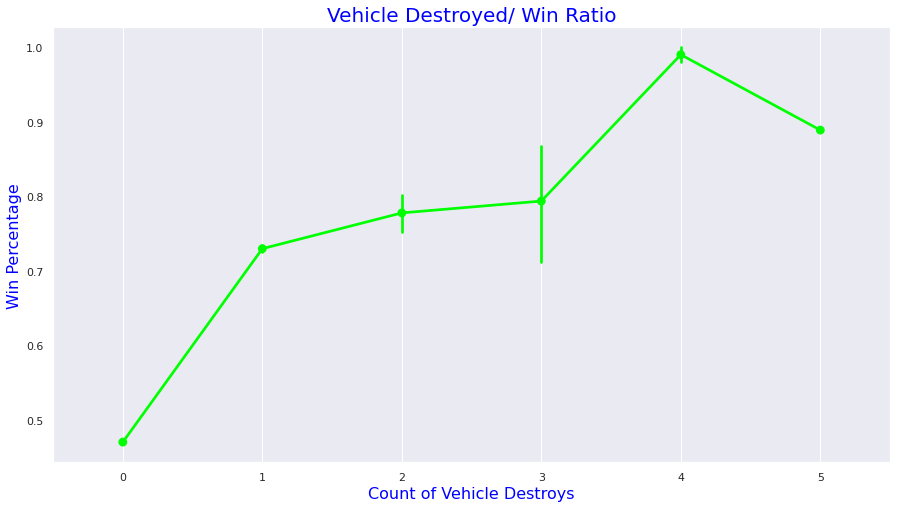

In [36]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=df,color='lime',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Vehicle Destroyed/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

Destroying vehicles increases your chances of winning!

**Analysing Healing and Boosting**

In [37]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(df['heals'].mean(), df['heals'].quantile(0.99), df['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(df['boosts'].mean(), df['boosts'].quantile(0.99), df['boosts'].max()))

In the game on an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 73.
In the game on an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 24.


**Analysing Healing and Boosting: Effect of Healing & Boosting on Winning Percentage**

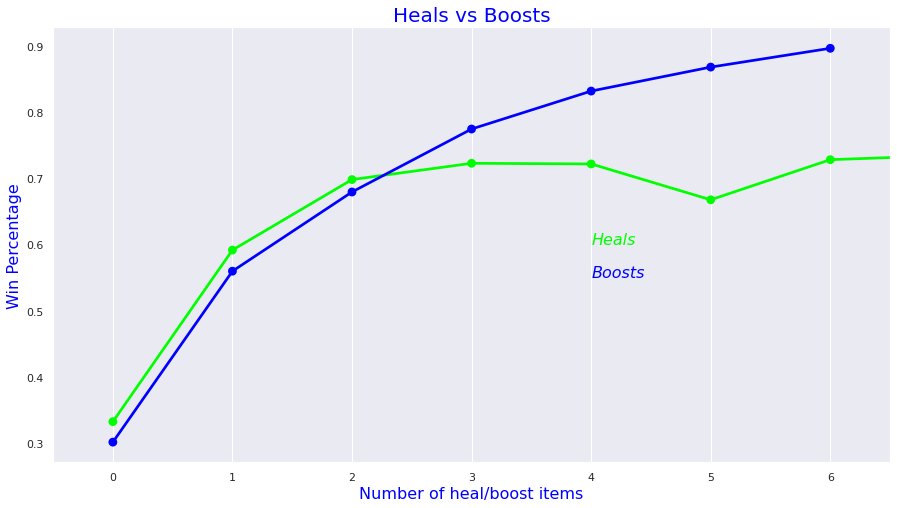

In [38]:
data = df.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

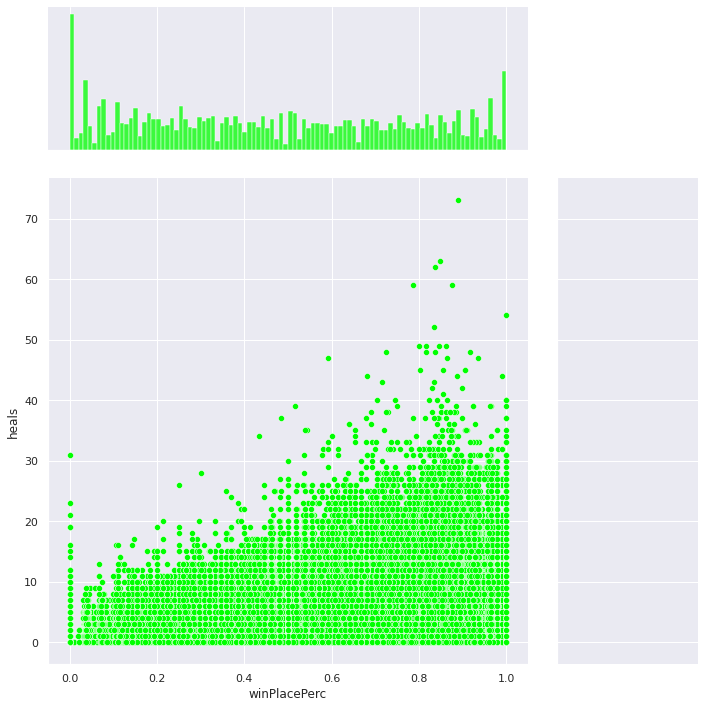

In [39]:
sns.jointplot(x="winPlacePerc", y="heals", data=df, height=10, ratio=3, color="lime")
plt.show()

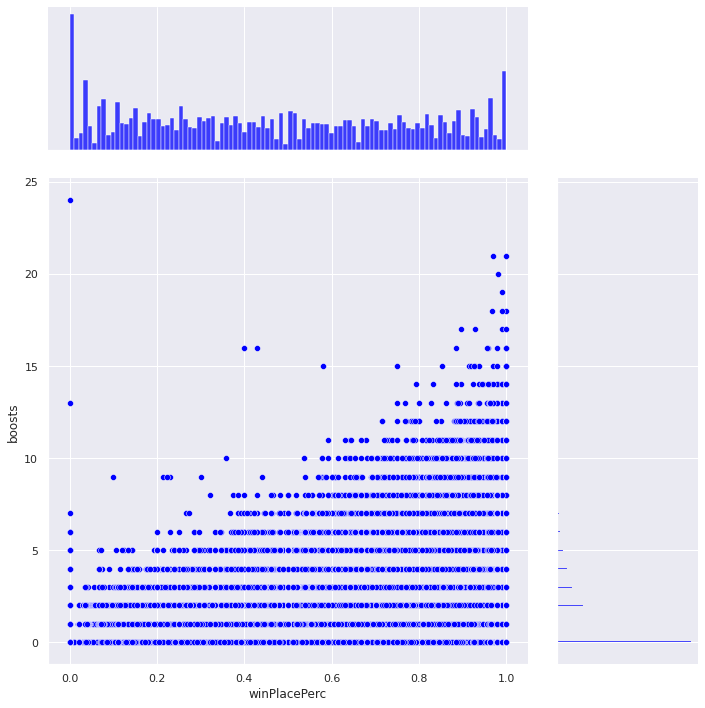

In [40]:
sns.jointplot(x="winPlacePerc", y="boosts", data=df, height=10, ratio=3, color="blue")
plt.show()

 Both healing and boosts have a high correlation with winning, however boosts matter more. Both the plots shows abnormal behaviour at 0

**Effect of Killing in different Game type: Solo, Duos and Squad on Winning Percentage**

In [41]:
solos = df[df['numGroups']>50] #Solo game played by more than 50 different groups
duos = df[(df['numGroups']>25) & (df['numGroups']<=50)] #Duo game can consist of a maximum of 50 groups(50x2=100) 
squads = df[df['numGroups']<=25] # Squad game can consist a maximum of 25 groups(25x4=100)
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(df), len(duos), 100*len(duos)/len(df), len(squads), 100*len(squads)/len(df),))

177161 (15.94%) of games are solo, 824015 (74.12%) are duo and 110566 (9.95%) are squad games.


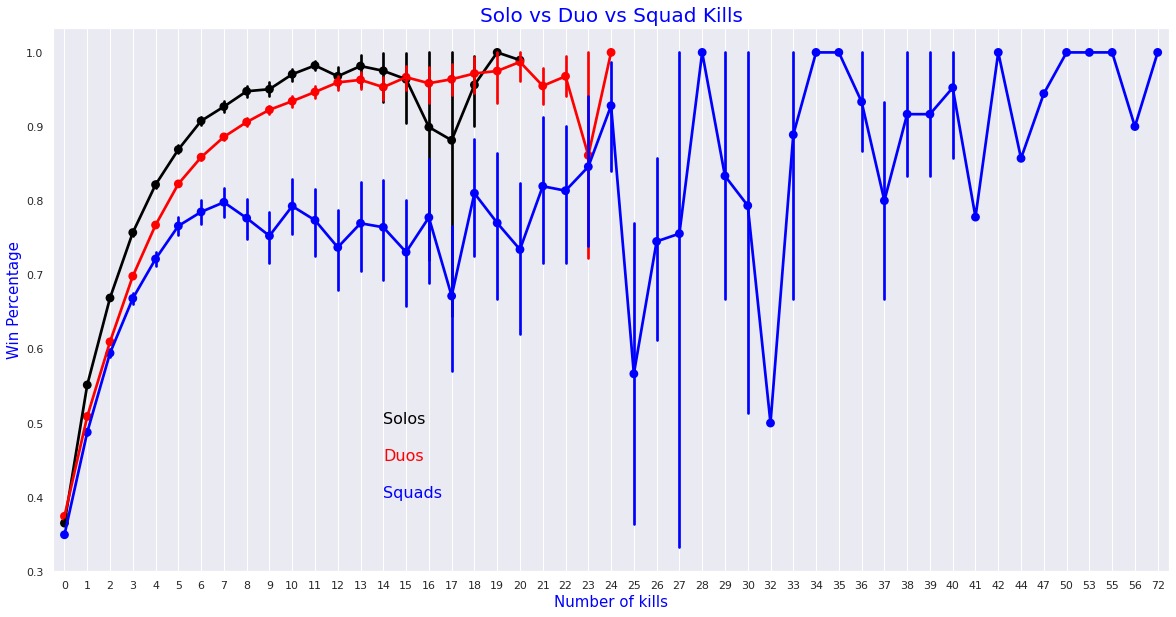

In [42]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='red',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='blue',alpha=0.6)
plt.text(14,0.5,'Solos',color='black',fontsize = 16)
plt.text(14,0.45,'Duos',color='red',fontsize = 16)
plt.text(14,0.4,'Squads',color='blue',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

**Multivariate analysis**

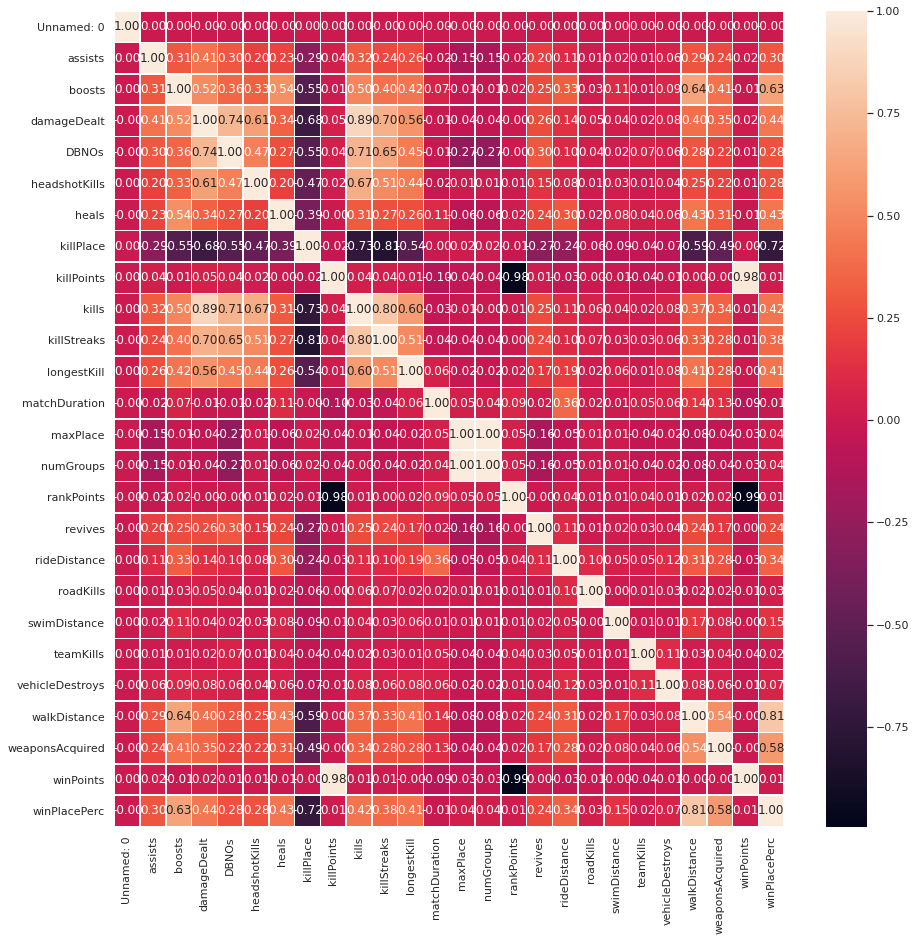

In [45]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

We can see, KillPoints and winpoints are highly correlated followed by walk distance and winPlacePrec

**Data Cleaning**: Outlier Detection and Removal - Finding the fraudsters¶

**Outliers**: How do we catch the fraudsters in the game?

Illegal match

In [47]:
# Check row with NaN value
df[df['winPlacePerc'].isnull()]


,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
184895,2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [48]:
df.drop(df[df['winPlacePerc'].isnull()].index, inplace=True)

In [49]:
df.shape


(1111741, 30)

In [52]:
# Engineer a new feature _totalDistance
df['_totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

Create a new feature 'headshot_rate'. We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

In [53]:
# Engineer _headshot_rate feature --- headshots made per kill
df['_headshot_rate'] = df['headshotKills'] / df['kills']
df['_headshot_rate'] = df['_headshot_rate'].fillna(0)

In [55]:
#Defining some functions for plotting graphs, we will be needing a lot of countplot and distplot
def show_countplot(column):
    plt.figure(figsize=(15,8))
    sns.countplot(data=df, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15, 8))
    sns.distplot(df[column], bins=50)
    plt.show()

**Inhumane kills**

Some rows in our dataset have weird characteristics. The players could be fraudsters, maniacs or just anomalies. Removing these outliers will likely improve results.

Let's take a look at the players who make these shots.

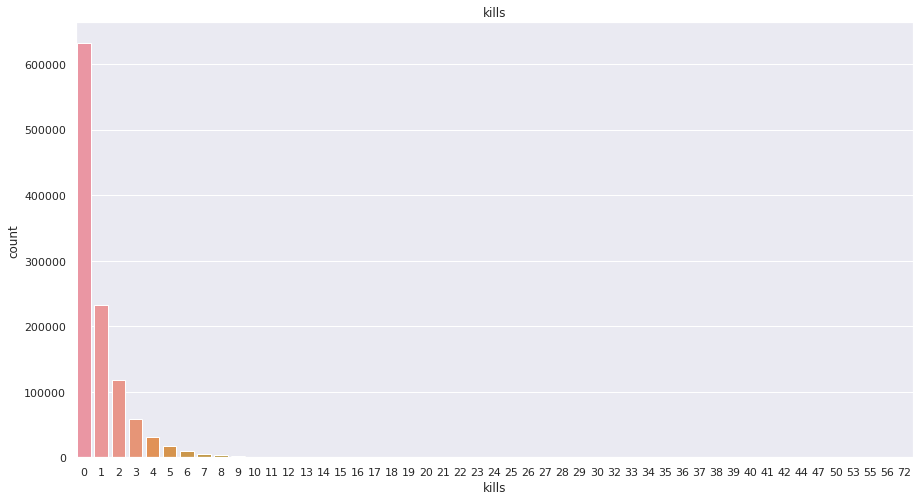

In [56]:
show_countplot('kills')


In [57]:
# Is it even possible to kill more than 40 people by acquiring more than 55 weapons and maintaining a total distance of less than 100m?
df[(df['kills'] >= 40) & (df['weaponsAcquired'] > 55) & (df['_totalDistance'] < 100.0)]

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
1036315,770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,0,55,6,74.79,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,85.55,66,0,1.0000,85.55,0.127273
1062585,1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,0,41,4,188.10,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,46.71,72,0,0.7778,46.71,0.121951


In [59]:
# Is it even possible to kill more than 40 people without using any heals?
df[(df['kills'] >= 40) & (df['heals'] == 0)]

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
373851,3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,1000,40,20,621.8,799,normal-squad-fpp,10,10,-1,0,0.0,0,0.0,0,0,1180.0,2,1500,1.0,1180.0,0.875


In [61]:
# Drop 'fraudsters' with inhumane kill counts
df.drop(df[(df['kills'] >= 40) & (df['weaponsAcquired'] > 55) & (df['_totalDistance'] < 100.0)].index, inplace=True)
df.drop(df[(df['kills'] >= 40) & (df['heals'] == 0)].index, inplace=True)

**100% head shot rate**

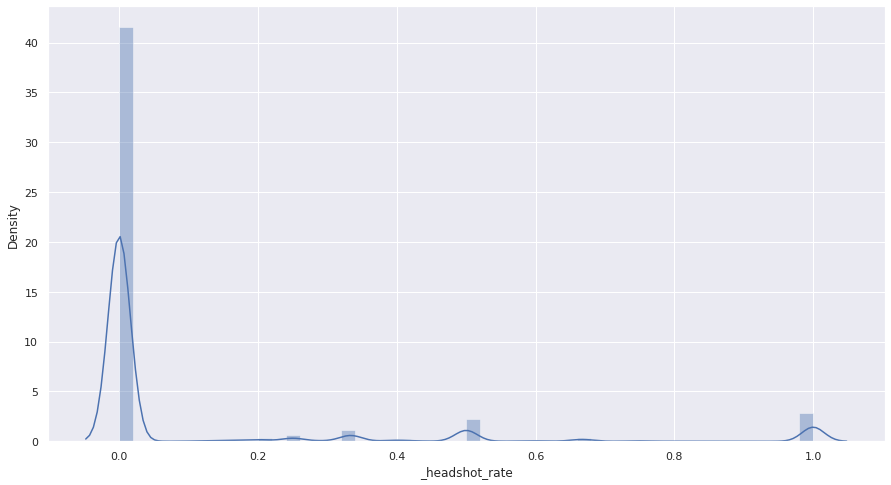

In [62]:
# Plot the distribution of headshot_rate
show_distplot('_headshot_rate')

In [63]:
# List of Hitman who made more than 10 kills and all the kills were done by headshot(perfect kill)
display(df[(df['_headshot_rate'] == 1) & (df['kills'] >=10)].shape)
df[(df['_headshot_rate'] == 1) & (df['kills'] >= 10)].head(10)

(4, 32)

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
445360,2256755,d8474df8d8283a,50c8a5b906d89d,c6da477a07f4aa,0,7,1569.0,0,14,0,1,0,14,2,453.8,1964,solo,95,92,1547,0,2785.0,0,0.0,0,0,2209.0,3,0,1.0,4994.0,1.0
577809,1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.0,1246,squad-fpp,27,27,-1,0,408.9,0,0.0,0,0,2450.0,7,1468,1.0,2858.9,1.0
596325,346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.6,1727,squad,27,26,-1,3,4720.0,0,0.0,0,0,3422.0,8,1560,1.0,8142.0,1.0
856491,963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.0,1417,squad,27,26,-1,0,1018.0,0,0.0,0,0,2458.0,4,1562,1.0,3476.0,1.0


It is unclear if these players are cheating or are the legends so for now we are not deleting these players from the dataset.

**Killing without Moving**

Identify the fraudsters who can making kills without even moving. So for this we first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without even moving a single inch.

In [64]:
# Create feature killsWithoutMoving
df['_killsWithoutMoving'] = ((df['kills'] > 0) & (df['_totalDistance'] == 0))
# Check players who kills without moving
display(df[df['_killsWithoutMoving'] == True].shape)
df[df['_killsWithoutMoving'] == True].head(10)

(375, 33)

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
1267,1535402,c80731765f5704,68345b2f762dc8,d38a14fb160874,5,0,1075.0,0,1,1,12,1000,9,3,73.7500,532,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,0,0,0.0,19,1500,0.1429,0.0,0.111111,True
2977,4061792,32cc8af554977f,a44a18784c7ad0,732c3b752e055f,1,0,190.3,0,0,0,37,0,1,1,0.9991,1939,solo-fpp,93,90,1579,0,0.0,0,0.0,0,0,0.0,1,0,0.0217,0.0,0.000000,True
5585,1573958,1ed752158c7bbc,338d6ab3bf5f19,4c6b1a0e4cb346,1,0,369.6,0,1,2,31,0,4,1,129.1000,1794,normal-squad-fpp,2,2,1500,0,0.0,0,0.0,2,0,0.0,27,0,1.0000,0.0,0.250000,True
9700,1845495,d4b5b144dbb5df,1e27daf256b9ad,59cd3bc39072e8,4,0,656.1,4,0,7,37,1000,3,1,61.4800,1063,normal-squad-fpp,5,5,-1,1,0.0,0,0.0,0,0,0.0,22,1500,0.2500,0.0,0.000000,True
10092,3803166,861fd334addd94,15ba030fd830cc,ed41b4340cd7af,1,0,524.4,0,0,2,20,1000,5,1,172.3000,1223,normal-duo-fpp,12,11,-1,0,0.0,0,0.0,0,0,0.0,14,1500,1.0000,0.0,0.000000,True
14025,1084495,a4d301a7407a07,25d19b1bf31ea3,cd535385c94139,0,2,297.3,5,2,8,29,1000,4,1,21.6400,898,normal-squad-fpp,6,6,-1,2,0.0,0,0.0,0,0,0.0,13,1500,0.0000,0.0,0.500000,True
14964,1997443,e88981e06fc0e7,d1cbdec91221d1,1aca7a1fad63bf,2,0,1902.0,0,0,1,1,1000,23,3,175.1000,996,normal-squad,6,6,-1,0,0.0,0,0.0,0,0,0.0,29,1500,0.6000,0.0,0.000000,True
16337,2262239,778e65309ef561,69c8c987979fb0,31179d2d545bba,2,0,520.4,5,1,0,24,0,4,2,38.3400,676,normal-squad-fpp,6,6,1500,3,0.0,0,0.0,0,0,0.0,13,0,1.0000,0.0,0.250000,True
17352,3760919,11463dca072357,055188f5012302,7dbdfc03179137,1,2,570.4,0,3,1,11,0,5,1,999.0000,897,normal-squad-fpp,3,3,1500,0,0.0,0,0.0,0,0,0.0,12,0,0.5000,0.0,0.600000,True
19418,3757251,96805fcf390f3e,dbe66c2c54cc90,3ebf1bf8bc6bae,4,4,1182.0,0,6,8,12,1000,12,2,192.7000,1136,normal-solo-fpp,30,17,-1,0,0.0,0,0.0,0,0,0.0,16,1500,0.9310,0.0,0.500000,True


In [66]:
# Drop kill without moving 'fraudsters'
df.drop(df[df['_killsWithoutMoving'] == True].index, inplace=True)

**Longest Kill**

Most kills are made from a distance of 100 meters or closer. However there are some players (outliers) who make a kill from more than 1km away. These players are probably fraudsters.

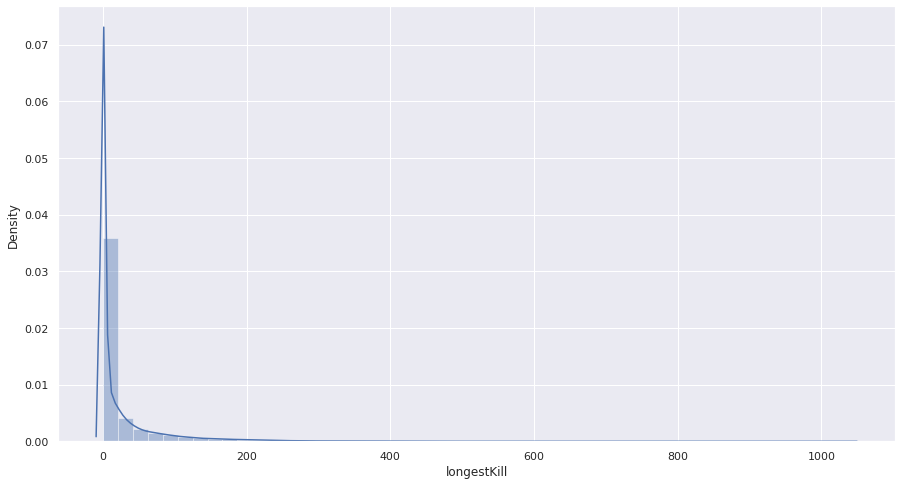

In [67]:
show_distplot('longestKill')


Is it even posssible to snipe (kill) someone from a distance > 1Km in this game?

Let's take a look at the players who took these shots.

In [68]:
df[df['longestKill'] >= 1000]


,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
101252,1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.0,0,0.00,0,0,2848.0,4,1500,0.9412,2848.00,0.466667,False
567594,4332473,d8857d3d7e31b6,085de7a36897e6,42f997c16d8a0e,5,0,1685.0,11,3,18,8,1000,16,2,1040.0,1793,normal-duo,12,11,-1,1,0.0,0,0.00,0,0,523.3,35,1500,0.9091,523.30,0.187500,False
644598,324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.0,0,0.00,0,0,1264.0,26,0,1.0000,2981.00,0.000000,False
878056,2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,0,11,2,1037.0,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.00,0,0,133.2,43,0,0.6000,133.20,0.545455,False
900761,2981715,7f77051c7cef52,d6579a630399b5,4784f7d9a06b51,3,5,1025.0,5,2,5,2,0,6,2,1003.0,1358,duo,47,44,1553,1,0.0,0,87.96,0,0,3998.0,7,0,1.0000,4085.96,0.333333,False
1055182,1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.0,0,0.00,0,0,832.5,9,1500,0.2857,832.50,0.000000,False


In [70]:
# Drop longestKill 'fraudsters'
df.drop(df[df['longestKill'] >= 1000].index, inplace=True)

Road Kills

In [72]:
# Players who got more than 10 roadKills
df[df['roadKills'] > 10]

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
139693,2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,1282.302,0.0,False


Did you noticed how c3e444f7d1289f rode just 5 meters but has killed 14 players in the roadkill. Got LUCKY or just another outlier?

In [73]:
# Drop roadKill 'fraudsters'
df.drop(df[df['roadKills'] > 10].index, inplace=True)

**Conclusions** :

1. kills has a high correlation with winPlacePerc.
2. Walking has a high correlation with winPlacePerc
3. Destroying vehicles increases your chances of winning!
4. Both healing and boosts have a high correlation with winning, however boosts matter more. Both the plots shows abnormal behaviour at 0
5. Solos and duos behave the same, but when playing squads kills don't matter that much.